In [ ]:
# Run this if facing issue with transformers then restart jupyter
# pip install torch torchvision torchaudio transformers

import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
from concurrent.futures import ThreadPoolExecutor
import json
import joblib
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, pipeline, BertForSequenceClassification, BertTokenizer
from telethon import TelegramClient, errors
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from tqdm.auto import tqdm
import asyncio
import nest_asyncio
nest_asyncio.apply()
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import optuna


from PnL_Metrics.Backtest import Backtest
from PnL_Metrics.PerformanceMetrics import ModelMetrics
from PnL_Metrics.PortfolioMetrics import PortfolioMetrics
from PnL_Metrics.TradeMetrics import TradingMetrics
from PnL_Metrics.WRC import WhiteRealityCheck

## Get Data

### Get BTC, ETH, BNB historical data from 2020-2025 at 5 min intervals

In [ ]:
# client = Client()

# def date_to_str(dt):
#     return dt.strftime('%d %b, %Y %H:%M:%S')

# def fetch_and_save(symbol, interval, start_date, end_date):
#     current_start = start_date
#     all_klines = []

#     while current_start < end_date:
#         current_end = min(current_start + timedelta(days=3), end_date)
#         klines = client.get_historical_klines(
#             symbol=symbol,
#             interval=interval,
#             start_str=date_to_str(current_start),
#             end_str=date_to_str(current_end)
#         )
#         if not klines:
#             break

#         all_klines.extend(klines)
#         print(f"{symbol}: Fetched {len(klines)} rows {current_start} to {current_end}")
#         current_start = datetime.fromtimestamp(klines[-1][0] / 1000.0) + timedelta(minutes=5)
#         time.sleep(0.5)

#     if all_klines:
#         df = pd.DataFrame(all_klines, columns=[
#             'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
#             'Close Time', 'Quote Asset Volume', 'Number of Trades',
#             'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
#         ])
#         df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms', utc=True, errors='coerce')
#         df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms', utc=True, errors='coerce')
#         df['Ticker'] = symbol
#         df = df.drop(columns=['Ignore'])
#         filename = f"{symbol}.csv"
#         df.to_csv(f"RawData/{filename}", index=False)
#         print(f"{symbol}: Saved {len(df)} rows to RawData/{filename}")
#     else:
#         print(f"{symbol}: No data fetched.")

# def runner(symbol):
#     start_date = datetime(2019, 12, 1)  # buffer before 2020
#     end_date = datetime(2025, 5, 31)
#     fetch_and_save(symbol, Client.KLINE_INTERVAL_5MINUTE, start_date, end_date)

# symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT']
# for symbol in symbols:
#     runner(symbol)

BTCUSDT: Fetched 865 rows 2019-12-01 00:00:00 to 2019-12-04 00:00:00
BTCUSDT: Fetched 865 rows 2019-12-04 08:05:00 to 2019-12-07 08:05:00
BTCUSDT: Fetched 865 rows 2019-12-07 16:10:00 to 2019-12-10 16:10:00
BTCUSDT: Fetched 865 rows 2019-12-11 00:15:00 to 2019-12-14 00:15:00
BTCUSDT: Fetched 865 rows 2019-12-14 08:20:00 to 2019-12-17 08:20:00
BTCUSDT: Fetched 865 rows 2019-12-17 16:25:00 to 2019-12-20 16:25:00
BTCUSDT: Fetched 865 rows 2019-12-21 00:30:00 to 2019-12-24 00:30:00
BTCUSDT: Fetched 865 rows 2019-12-24 08:35:00 to 2019-12-27 08:35:00
BTCUSDT: Fetched 865 rows 2019-12-27 16:40:00 to 2019-12-30 16:40:00
BTCUSDT: Fetched 865 rows 2019-12-31 00:45:00 to 2020-01-03 00:45:00
BTCUSDT: Fetched 865 rows 2020-01-03 08:50:00 to 2020-01-06 08:50:00
BTCUSDT: Fetched 865 rows 2020-01-06 16:55:00 to 2020-01-09 16:55:00
BTCUSDT: Fetched 865 rows 2020-01-10 01:00:00 to 2020-01-13 01:00:00
BTCUSDT: Fetched 865 rows 2020-01-13 09:05:00 to 2020-01-16 09:05:00
BTCUSDT: Fetched 865 rows 2020-01-

### Get Tele data

In [ ]:
# api_id = 25170345
# api_hash = '782970020305efee143d83f63103a9d9'
# session_name = 'new_session'

# channels = ['cointelegraph', 'wublockchainenglish', 'watcherguru']
# start_date = datetime(2019, 12, 1, tzinfo=timezone.utc) # buffer
# end_date = datetime(2025, 5, 31, tzinfo=timezone.utc)

# client = TelegramClient(session_name, api_id, api_hash)

# async def scrape_channel(channel_username, start_date, end_date):
#     if not client.is_connected():
#         await client.start()

#     messages = []

#     try:
#         async for msg in client.iter_messages(channel_username, offset_date=end_date):
#             if msg.date < start_date:
#                 break
#             if msg.message:
#                 messages.append({
#                     'channel': channel_username,
#                     'text': msg.message,
#                     'timestamp': msg.date
#                 })
#             if len(messages) % 500 == 0:
#                 print(f"{channel_username}: Collected {len(messages)} messages so far...")

#     except errors.FloodWaitError as e:
#         print(f"{channel_username}: Flood wait hit. Sleeping {e.seconds} seconds...")
#         await asyncio.sleep(e.seconds + 1)
#         return await scrape_channel(channel_username, start_date, end_date)

#     except errors.ConnectionError:
#         print(f"{channel_username}: Disconnected. Reconnecting...")
#         await client.connect()
#         return await scrape_channel(channel_username, start_date, end_date)

#     print(f"{channel_username}: Total messages collected: {len(messages)}")
#     return pd.DataFrame(messages)

# async def main():
#     dfs = []
#     for channel in channels:
#         df = await scrape_channel(channel, start_date, end_date)
#         dfs.append(df)
    
#     tele_df = pd.concat(dfs, ignore_index=True)
#     return tele_df

# tele_df = await main()

Signed in successfully as Test Goh; remember to not break the ToS or you will risk an account ban!
cointelegraph: Collected 500 messages so far...
cointelegraph: Collected 500 messages so far...
cointelegraph: Collected 1000 messages so far...
cointelegraph: Collected 1500 messages so far...
cointelegraph: Collected 2000 messages so far...
cointelegraph: Collected 2000 messages so far...
cointelegraph: Collected 2500 messages so far...
cointelegraph: Collected 3000 messages so far...
cointelegraph: Collected 3500 messages so far...
cointelegraph: Collected 3500 messages so far...
cointelegraph: Collected 4000 messages so far...
cointelegraph: Collected 4500 messages so far...
cointelegraph: Collected 5000 messages so far...
cointelegraph: Collected 5500 messages so far...
cointelegraph: Collected 6000 messages so far...
cointelegraph: Collected 6500 messages so far...
cointelegraph: Collected 7000 messages so far...
cointelegraph: Collected 7500 messages so far...
cointelegraph: Collec

Server sent a very old message with ID 7519936807263173633, ignoring (see FAQ for details)
Server sent a very old message with ID 7519936842780470273, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938624549122049, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938670742951937, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938848659787777, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938913185280001, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938924199960577, ignoring (see FAQ for details)
Server sent a very old message with ID 7519938942070627329, ignoring (see FAQ for details)
Server sent a very old message with ID 7519939507993946113, ignoring (see FAQ for details)
Server sent a very old message with ID 7519939507999491073, ignoring (see FAQ for details)
Security error while unpacking a received message: Too many messages had to be ignored con

In [ ]:
# tele_df.to_csv(f'RawData/tele_df.csv', index=False)
# tele_df = pd.read_csv('RawData/tele_df.csv')
# tele_df['timestamp'] = pd.to_datetime(tele_df['timestamp'], utc=True, errors='coerce')
# tele_df = tele_df.sort_values('timestamp').reset_index(drop=True)
# tele_df = tele_df[tele_df['timestamp'] <= pd.Timestamp('2025-05-31', tz='UTC')].reset_index(drop=True)
# tele_df

,channel,text,timestamp
0,cointelegraph,⁠Richard Heart is pitching his new controversi...,2019-12-01 07:52:04+00:00
1,cointelegraph,⁠Georgia’s Governor is expected to appoint Bak...,2019-12-01 08:36:37+00:00
2,cointelegraph,⁠A new blockchain card game based on an 80s be...,2019-12-01 09:44:30+00:00
3,cointelegraph,⁠Bitcoin could be preparing to fill $7.8K futu...,2019-12-01 10:22:03+00:00
4,cointelegraph,⁠Will Libra be able to operate in the U.S. if ...,2019-12-01 13:41:05+00:00
...,...,...,...
66943,wublockchainenglish,Bloomberg analyst James Seyffart stated that R...,2025-05-30 21:06:20+00:00
66944,wublockchainenglish,Brazilian fintech company Méliuz has announced...,2025-05-30 21:51:26+00:00
66945,watcherguru,JUST IN: SharpLink Gaming to raise $1 billion ...,2025-05-30 22:00:29+00:00
66946,wublockchainenglish,"On May 30, 2025, SharpLink Gaming filed a Form...",2025-05-30 22:30:34+00:00


### Get Sentiment Scores (using pretrained Cryptobert)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
# model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert")
# tele_sentiment_df = tele_df.copy()

# def get_sentiment_scores(texts, batch_size=16):
#     all_probs = []

#     for i in tqdm(range(0, len(texts), batch_size), desc="Scoring sentiment"):
#         batch_texts = texts[i:i+batch_size]
#         inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

#         with torch.no_grad():
#             outputs = model(**inputs)
#             logits = outputs.logits
#             probs = torch.softmax(logits, dim=1).numpy()

#         all_probs.extend(probs)

#     return all_probs

# probs = get_sentiment_scores(tele_sentiment_df['text'].tolist())

# tele_sentiment_df['bullish_prob'] = [p[0] for p in probs]
# tele_sentiment_df['bearish_prob'] = [p[1] for p in probs]
# tele_sentiment_df['neutral_prob'] = [p[2] for p in probs]

# print(tele_sentiment_df.head())

Scoring sentiment: 100%|██████████| 4185/4185 [39:44<00:00,  1.76it/s]

         channel                                               text  \
0  cointelegraph  ⁠Richard Heart is pitching his new controversi...   
1  cointelegraph  ⁠Georgia’s Governor is expected to appoint Bak...   
2  cointelegraph  ⁠A new blockchain card game based on an 80s be...   
3  cointelegraph  ⁠Bitcoin could be preparing to fill $7.8K futu...   
4  cointelegraph  ⁠Will Libra be able to operate in the U.S. if ...   

                  timestamp  bullish_prob  bearish_prob  neutral_prob  
0 2019-12-01 07:52:04+00:00      0.000600      0.791516      0.207884  
1 2019-12-01 08:36:37+00:00      0.000729      0.866833      0.132438  
2 2019-12-01 09:44:30+00:00      0.000081      0.701631      0.298288  
3 2019-12-01 10:22:03+00:00      0.002727      0.944465      0.052809  
4 2019-12-01 13:41:05+00:00      0.000187      0.940059      0.059754  


## Load Data

### Load BTC and features data

In [ ]:
files = glob.glob('RawData\*USDT*.csv')
dfs = []
for file in files:
    df = pd.read_csv(file)
    if 'Ignore' in df.columns:
        df = df.drop(columns=['Ignore'])
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
full_df['Open Time'] = pd.to_datetime(full_df['Open Time'], utc=True, errors='coerce')
full_df['Close Time'] = pd.to_datetime(full_df['Close Time'], utc=True, errors='coerce')
full_df = full_df.drop_duplicates()
full_df = full_df.sort_values('Open Time').reset_index(drop=True)

# Load BTC data only
btc_df= full_df[full_df['Ticker'] == 'BTCUSDT'].copy()
btc_df = btc_df.reset_index(drop=True)

### Target variable labelling

In [5]:
btc_df = btc_df.sort_values("Open Time").reset_index(drop=True)
btc_df["target"] = (btc_df["Close"].shift(-1) > btc_df["Close"]).astype(int)
btc_df = btc_df.dropna().reset_index(drop=True)

### Append with raw technical features

In [6]:
df = btc_df.copy().sort_values("Open Time").reset_index(drop=True)

num_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Quote Asset Volume", "Taker Buy Base Asset Volume",
    "Taker Buy Quote Asset Volume"
]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["pct_change"] = df["Close"].pct_change()
df["Close-Open"] = df["Close"] - df["Open"]
df["Bar_Direction"] = np.sign(df["Close"] - df["Open"])
df["Bar_Change_Direction"] = np.sign(df["Close"] - df["Close"].shift(1))

for N in (6, 12):
    df[f"roll_mean_ret_{N}"] = df["log_return"].rolling(N).mean()
    df[f"roll_std_ret_{N}"] = df["log_return"].rolling(N).std()
    df[f"roll_mean_close_{N}"] = df["Close"].rolling(N).mean()
    df[f"roll_std_close_{N}"] = df["Close"].rolling(N).std()
    df[f"roll_high_{N}"] = df["High"].rolling(N).max()
    df[f"roll_low_{N}"] = df["Low"].rolling(N).min()
    df[f"stoch_raw_{N}"] = (df["Close"] - df[f"roll_low_{N}"]) / (df[f"roll_high_{N}"] - df[f"roll_low_{N}"] + 1e-9)
    df[f"roll_range_{N}"] = df["High"].rolling(N).max() - df["Low"].rolling(N).min()
    df[f"roll_mean_vol_{N}"] = df["Volume"].rolling(N).mean()
    df[f"vol_surge_{N}"] = df["Volume"] / (df[f"roll_mean_vol_{N}"] + 1e-9)
    df[f"roll_sum_signed_vol_{N}"] = (df["Volume"] * np.sign(df["Close"] - df["Close"].shift(1))).rolling(N).sum()

df["EMA_6"] = df["Close"].ewm(span=6, adjust=False).mean()
df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_24"] = df["Close"].ewm(span=24, adjust=False).mean()

prev_close = df["Close"].shift(1)
df["True_Range"] = np.maximum.reduce([
    df["High"] - df["Low"],
    (df["High"] - prev_close).abs(),
    (df["Low"] - prev_close).abs()
])

up_move = df["High"] - df["High"].shift(1)
down_move = df["Low"].shift(1) - df["Low"]
df["+DM"] = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
df["-DM"] = np.where((down_move > up_move) & (down_move > 0), down_move, 0)

df["pos_return"] = np.where(df["Close"] > df["Close"].shift(1), df["Close"] - df["Close"].shift(1), 0)
df["neg_return"] = np.where(df["Close"] < df["Close"].shift(1), df["Close"].shift(1) - df["Close"], 0)
df["roll_pos_ret_6"] = df["pos_return"].rolling(6).mean()
df["roll_neg_ret_6"] = df["neg_return"].rolling(6).mean()
df["roll_pos_ret_12"] = df["pos_return"].rolling(12).mean()
df["roll_neg_ret_12"] = df["neg_return"].rolling(12).mean()

df["avg_trade_size"] = df["Volume"] / (df["Number of Trades"] + 1e-9)
df["taker_buy_ratio"] = df["Taker Buy Base Asset Volume"] / (df["Volume"] + 1e-9)

features_df = df.dropna().reset_index(drop=True)

In [ ]:
# features_df.to_csv(f'RawData/features_df.csv', index=False)
features_df = pd.read_csv('RawData/features_df.csv')
features_df['Open Time'] = pd.to_datetime(features_df['Open Time'], utc=True, errors='coerce')
features_df['Close Time'] = pd.to_datetime(features_df['Close Time'], utc=True, errors='coerce')
features_df = features_df.sort_values('Open Time').reset_index(drop=True)

### Load Tele and Sentiment Data

In [ ]:
#tele_sentiment_df.to_csv('RawData/tele_sentiment_df.csv', index=False)
tele_sentiment_df = pd.read_csv("RawData\tele_sentiment_df.csv")
tele_sentiment_df['timestamp'] = pd.to_datetime(tele_sentiment_df['timestamp'], utc=True, errors='coerce')
tele_sentiment_df = tele_sentiment_df.sort_values('timestamp').reset_index(drop=True)
tele_sentiment_df

,channel,text,timestamp,bullish_prob,bearish_prob,neutral_prob
0,cointelegraph,⁠Richard Heart is pitching his new controversi...,2019-12-01 07:52:04+00:00,0.000600,0.791516,0.207884
1,cointelegraph,⁠Georgia’s Governor is expected to appoint Bak...,2019-12-01 08:36:37+00:00,0.000729,0.866833,0.132438
2,cointelegraph,⁠A new blockchain card game based on an 80s be...,2019-12-01 09:44:30+00:00,0.000081,0.701631,0.298288
3,cointelegraph,⁠Bitcoin could be preparing to fill $7.8K futu...,2019-12-01 10:22:03+00:00,0.002727,0.944465,0.052809
4,cointelegraph,⁠Will Libra be able to operate in the U.S. if ...,2019-12-01 13:41:05+00:00,0.000187,0.940059,0.059754
...,...,...,...,...,...,...
66943,wublockchainenglish,Bloomberg analyst James Seyffart stated that R...,2025-05-30 21:06:20+00:00,0.000098,0.530250,0.469652
66944,wublockchainenglish,Brazilian fintech company Méliuz has announced...,2025-05-30 21:51:26+00:00,0.000206,0.797950,0.201844
66945,watcherguru,JUST IN: SharpLink Gaming to raise $1 billion ...,2025-05-30 22:00:29+00:00,0.000350,0.376076,0.623574
66946,wublockchainenglish,"On May 30, 2025, SharpLink Gaming filed a Form...",2025-05-30 22:30:34+00:00,0.000270,0.334554,0.665176


## Data Preprocessing

In [ ]:
def attach_sentiment_to_features(features_df, tele_sentiment_df):
    agg_results = []

    for _, row in features_df.iterrows():
        mask = (tele_sentiment_df['timestamp'] < row['Open Time']) & (tele_sentiment_df['timestamp'] >= row['Open Time'] - pd.Timedelta(minutes=5))
        subset = tele_sentiment_df[mask]

        if len(subset) > 0:
            agg_results.append({
                'mean_bullish_prob': subset['bullish_prob'].mean(),
                'mean_bearish_prob': subset['bearish_prob'].mean(),
                'mean_neutral_prob': subset['neutral_prob'].mean(),
                'msg_count': len(subset)
            })
        else:
            agg_results.append({
                'mean_bullish_prob': float('nan'),
                'mean_bearish_prob': float('nan'),
                'mean_neutral_prob': float('nan'),
                'msg_count': 0
            })

    sentiment_df = pd.DataFrame(agg_results)
    final_df = pd.concat([features_df.reset_index(drop=True), sentiment_df], axis=1)
    return final_df

final_df = attach_sentiment_to_features(features_df, tele_sentiment_df)
# final_df.to_csv('RawData/final_df.csv', index=False)

## Start

In [ ]:
#final_df = pd.read_csv('RawData\final_df.csv')
final_df['Open Time'] = pd.to_datetime(final_df['Open Time'], utc=True, errors='coerce')
final_df['Close Time'] = pd.to_datetime(final_df['Close Time'], utc=True, errors='coerce')
final_df = final_df.drop(columns=['msg_count'])

# Forward fill missing sentiment if no msg within past 5 mins
final_df[['mean_bullish_prob', 'mean_bearish_prob', 'mean_neutral_prob']] = (
    final_df[['mean_bullish_prob', 'mean_bearish_prob', 'mean_neutral_prob']].ffill()
)

final_df = final_df[final_df['Open Time'] >= pd.Timestamp('2020-01-01', tz='UTC')].reset_index(drop=True)

In [11]:
final_df['target'].value_counts()

target
0    256217
1    255962
Name: count, dtype: int64

### Walk Forward Train Val Test Split

In [12]:
exclude_cols = ['Close Time', 'Ticker']
feature_cols = [col for col in final_df.columns if col not in exclude_cols]
model_df = final_df[feature_cols].copy()

In [13]:
def generate_walk_forward_splits(df, seq_len=12, train_years=2.5, val_months=9, step_months=9, holdout_start="2024-10-01"):
    holdout_start = pd.to_datetime(holdout_start, utc=True)
    folds_data = []
    folds_dataframes = []
    splits = []

    min_time = df['Open Time'].min()
    max_time = holdout_start - pd.Timedelta(seconds=1)

    years_int = int(train_years)
    months_int = int((train_years - years_int) * 12)

    current_train_end = (min_time + pd.DateOffset(years=years_int, months=months_int) - pd.Timedelta(seconds=1))
    fold_idx = 1

    while True:
        val_start = current_train_end + pd.Timedelta(seconds=1)
        val_end = val_start + pd.DateOffset(months=val_months) - pd.Timedelta(seconds=1)

        if val_end >= max_time:
            break

        train_df = df[(df['Open Time'] >= min_time) & (df['Open Time'] <= current_train_end)]
        val_df = df[(df['Open Time'] >= val_start) & (df['Open Time'] <= val_end)]

        splits.append({
            'train_start': min_time,
            'train_end': current_train_end,
            'val_start': val_start,
            'val_end': val_end
        })

        folds_dataframes.append({
            'train_df': train_df,
            'val_df': val_df
        })

        print(f"Fold {fold_idx}: Train={len(train_df)}, Val={len(val_df)}")
        fold_idx += 1

        current_train_end = current_train_end + pd.DateOffset(months=step_months)

    feature_cols = [col for col in df.columns if col not in ['Open Time', 'target']]
    target_col = 'target'

    def create_sliding_windows(df_inner):
        X, y = [], []
        data = df_inner[feature_cols].values
        target = df_inner[target_col].values
        for i in range(len(df_inner) - seq_len):
            X.append(data[i:i + seq_len])
            y.append(target[i + seq_len])
        return np.array(X), np.array(y)

    for i, f in enumerate(folds_dataframes, 1):
        X_train, y_train = create_sliding_windows(f['train_df'])
        X_val, y_val = create_sliding_windows(f['val_df'])

        folds_data.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val
        })

        print(f"Fold {i} shapes: X_train={X_train.shape}, X_val={X_val.shape}")

    return splits, folds_dataframes, folds_data


def get_holdout_test_data(df, seq_len=12, holdout_start="2024-10-01", holdout_end="2025-05-31"):
    holdout_start = pd.to_datetime(holdout_start, utc=True)
    holdout_end = pd.to_datetime(holdout_end, utc=True)

    test_df = df[(df['Open Time'] >= holdout_start) & (df['Open Time'] <= holdout_end)]

    feature_cols = [col for col in df.columns if col not in ['Open Time', 'target']]
    target_col = 'target'

    data = test_df[feature_cols].values
    target = test_df[target_col].values
    X_test, y_test = [], []

    for i in range(len(test_df) - seq_len):
        X_test.append(data[i:i + seq_len])
        y_test.append(target[i + seq_len])

    return np.array(X_test), np.array(y_test), test_df.reset_index(drop=True)

In [14]:
splits, folds_dataframes, all_fold_data = generate_walk_forward_splits(model_df, seq_len=12)

Fold 1: Train=236098, Val=71024
Fold 2: Train=306834, Val=71328
Fold 3: Train=378162, Val=70947
Fold 1 shapes: X_train=(236086, 12, 53), X_val=(71012, 12, 53)
Fold 2 shapes: X_train=(306822, 12, 53), X_val=(71316, 12, 53)
Fold 3 shapes: X_train=(378150, 12, 53), X_val=(70935, 12, 53)


### Scale

In [ ]:
def scale_folds(all_fold_data, feature_cols, folds_dataframes):
    all_fold_data_scaled = []

    for i, (fold, df_set) in enumerate(zip(all_fold_data, folds_dataframes), 1):
        scaler = StandardScaler()
        
        scaler.fit(df_set['train_df'][feature_cols].values)

        def scale_X(X):
            n_samples, seq_len, n_features = X.shape
            X_flat = X.reshape(-1, n_features)
            X_scaled_flat = scaler.transform(X_flat)
            return X_scaled_flat.reshape(n_samples, seq_len, n_features)

        fold_scaled = {
            'X_train': scale_X(fold['X_train']),
            'y_train': fold['y_train'],
            'X_val': scale_X(fold['X_val']),
            'y_val': fold['y_val'],
            'scaler': scaler
        }

        if 'X_test' in fold:
            fold_scaled['X_test'] = scale_X(fold['X_test'])
            fold_scaled['y_test'] = fold['y_test']

        all_fold_data_scaled.append(fold_scaled)

        print(f"Fold {i} scaled: X_train={fold_scaled['X_train'].shape}, X_val={fold_scaled['X_val'].shape}" +
              (f", X_test={fold_scaled['X_test'].shape}" if 'X_test' in fold_scaled else ""))

    return all_fold_data_scaled

In [16]:
feature_cols = [col for col in model_df.columns if col not in ['Open Time', 'target']]

# Scale the folds
all_fold_data_scaled = scale_folds(
    all_fold_data=all_fold_data,
    feature_cols=feature_cols,
    folds_dataframes=folds_dataframes
)

Fold 1 scaled: X_train=(236086, 12, 53), X_val=(71012, 12, 53)
Fold 2 scaled: X_train=(306822, 12, 53), X_val=(71316, 12, 53)
Fold 3 scaled: X_train=(378150, 12, 53), X_val=(70935, 12, 53)


### SegRNN

In [ ]:

class AttentionSegRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)  # output: raw logits

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        attn_weights = torch.softmax(self.attn(rnn_out).squeeze(-1), dim=1)
        context = torch.sum(rnn_out * attn_weights.unsqueeze(-1), dim=1)
        out = self.fc(context).squeeze(-1)  # (B,), raw logits
        return out

def train_model(model, X_train, y_train, X_val, lr, batch_size, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch).view(-1)
            y_batch = y_batch.view(-1)

            assert outputs.shape == y_batch.shape, f"{outputs.shape} vs {y_batch.shape}"
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor).view(-1).cpu().numpy()
        val_probs  = 1 / (1 + np.exp(-val_logits))  # apply sigmoid manually

    return model, val_probs

def run_optuna(
        X_train, y_train,
        X_val, val_df,
        seq_len,
        n_trials=5,
        save_path="SegRNN Files/best_segrnn_params.json",
        fixed_thresh=0.50
    ):

    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
        num_layers = trial.suggest_int('num_layers', 1, 3)
        dropout = trial.suggest_float('dropout', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        model = AttentionSegRNN(
            input_dim = X_train.shape[2],
            hidden_dim = hidden_dim,
            num_layers = num_layers,
            dropout = dropout
        )

        try:
            _, val_preds = train_model(
                model, X_train, y_train, X_val,
                lr=lr, batch_size=batch_size
            )
        except RuntimeError as e:
            print(f"Runtime error during training: {e}")
            return -1.0 # penalize the trial

        val_df_trimmed = val_df.reset_index(drop=True).iloc[seq_len:].copy()
        val_preds_trim = val_preds[:len(val_df_trimmed)]

        mask = val_df_trimmed["target"].notna() & val_df_trimmed["Close"].notna()
        y_true = val_df_trimmed.loc[mask, "target"].values
        y_prob = val_preds_trim[mask.values]

        if len(y_true) == 0 or len(y_prob) == 0:
            print("Warning: Empty prediction/label set")
            return -1.0

        y_pred_class = (y_prob >= fixed_thresh).astype(int)
        f1 = f1_score(y_true, y_pred_class, zero_division=0)

        return f1

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_params)
    print(f"Best F1 on validation: {study.best_value:.4f}")

    with open(save_path, "w") as fp:
        json.dump(study.best_params, fp, indent=2)

    return study.best_params, study.best_value


In [ ]:
seq_len = 12  # must match what was used during fold generation

for fold_idx, (fold_data, fold_df) in enumerate(zip(all_fold_data_scaled, folds_dataframes), 1):
    print(f"\n=== Running Fold {fold_idx} ===")

    X_train = fold_data['X_train']
    y_train = fold_data['y_train']
    X_val = fold_data['X_val']

    # IMPORTANT: do NOT slice with iloc[seq_len:], its handled inside run_optuna
    val_df_for_pnl = fold_df['val_df']

    best_params, best_score = run_optuna(
        X_train,
        y_train,
        X_val,
        val_df=val_df_for_pnl,
        seq_len=seq_len,
        n_trials=5,
        save_path=f"SegRNN Files/best_segrnn_params_fold{fold_idx}.json"
    )

    print(f"Fold {fold_idx} best params: {best_params}")
    print(f"Fold {fold_idx} best score: {best_score:.4f}")

[I 2025-06-26 22:25:52,911] A new study created in memory with name: no-name-6158396d-3d50-4e5b-a718-0a32665ec390



=== Running Fold 1 ===


Best trial: 0. Best value: 0.601933:  20%|██        | 1/5 [05:02<20:08, 302.13s/it]

[I 2025-06-26 22:30:55,046] Trial 0 finished with value: 0.601932929669306 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.28660642711731404, 'lr': 0.0031645768399056274, 'batch_size': 32}. Best is trial 0 with value: 0.601932929669306.


Best trial: 0. Best value: 0.601933:  40%|████      | 2/5 [06:12<08:16, 165.59s/it]

[I 2025-06-26 22:32:05,049] Trial 1 finished with value: 0.5291977790541834 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3924773003154241, 'lr': 0.0002738506873160283, 'batch_size': 128}. Best is trial 0 with value: 0.601932929669306.


Best trial: 0. Best value: 0.601933:  60%|██████    | 3/5 [07:39<04:19, 129.95s/it]

[I 2025-06-26 22:33:32,591] Trial 2 finished with value: 0.5988674178294121 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.45369126360413287, 'lr': 0.00010410732178289506, 'batch_size': 128}. Best is trial 0 with value: 0.601932929669306.


Best trial: 0. Best value: 0.601933:  80%|████████  | 4/5 [09:52<02:11, 131.01s/it]

[I 2025-06-26 22:35:45,217] Trial 3 finished with value: 0.5909376742640865 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.1157893055978389, 'lr': 0.0005740925580224088, 'batch_size': 64}. Best is trial 0 with value: 0.601932929669306.


Best trial: 4. Best value: 0.66073: 100%|██████████| 5/5 [11:03<00:00, 132.64s/it] 
[I 2025-06-26 22:36:56,090] A new study created in memory with name: no-name-d2be0cc8-7008-489e-82a1-5ba8a5436c76


[I 2025-06-26 22:36:56,087] Trial 4 finished with value: 0.660729741686061 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.42303687128201356, 'lr': 0.005949352121328818, 'batch_size': 128}. Best is trial 4 with value: 0.660729741686061.

Best hyperparameters:
{'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.42303687128201356, 'lr': 0.005949352121328818, 'batch_size': 128}
Best F1 on validation: 0.6607
Fold 1 best params: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.42303687128201356, 'lr': 0.005949352121328818, 'batch_size': 128}
Fold 1 best score: 0.6607

=== Running Fold 2 ===


Best trial: 0. Best value: 0.49662:  20%|██        | 1/5 [01:26<05:44, 86.12s/it]

[I 2025-06-26 22:38:22,209] Trial 0 finished with value: 0.49662016395800374 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.48403999249752244, 'lr': 0.001962334059885722, 'batch_size': 128}. Best is trial 0 with value: 0.49662016395800374.


Best trial: 1. Best value: 0.557705:  40%|████      | 2/5 [03:05<04:42, 94.10s/it]

[I 2025-06-26 22:40:01,888] Trial 1 finished with value: 0.5577046076700694 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.14450471665134895, 'lr': 0.006075999879870354, 'batch_size': 128}. Best is trial 1 with value: 0.5577046076700694.


Best trial: 1. Best value: 0.557705:  60%|██████    | 3/5 [05:08<03:34, 107.29s/it]

[I 2025-06-26 22:42:04,884] Trial 2 finished with value: 0.47612616668167224 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.010583299850445038, 'lr': 0.00019425769392784415, 'batch_size': 128}. Best is trial 1 with value: 0.5577046076700694.


Best trial: 1. Best value: 0.557705:  80%|████████  | 4/5 [10:05<03:02, 182.08s/it]

[I 2025-06-26 22:47:01,616] Trial 3 finished with value: 0.25151464153483677 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.35688470714258663, 'lr': 0.009098390957515617, 'batch_size': 32}. Best is trial 1 with value: 0.5577046076700694.


Best trial: 1. Best value: 0.557705: 100%|██████████| 5/5 [11:54<00:00, 142.82s/it]
[I 2025-06-26 22:48:50,177] A new study created in memory with name: no-name-8dd12df1-60ec-4a01-88be-807cfb88862c


[I 2025-06-26 22:48:50,174] Trial 4 finished with value: 0.5409439714075476 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.21002811893575096, 'lr': 0.0016046365444724604, 'batch_size': 128}. Best is trial 1 with value: 0.5577046076700694.

Best hyperparameters:
{'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.14450471665134895, 'lr': 0.006075999879870354, 'batch_size': 128}
Best F1 on validation: 0.5577
Fold 2 best params: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.14450471665134895, 'lr': 0.006075999879870354, 'batch_size': 128}
Fold 2 best score: 0.5577

=== Running Fold 3 ===


Best trial: 0. Best value: 0.356279:  20%|██        | 1/5 [04:17<17:11, 257.82s/it]

[I 2025-06-26 22:53:07,999] Trial 0 finished with value: 0.35627906976744184 and parameters: {'hidden_dim': 32, 'num_layers': 3, 'dropout': 0.42212954883855097, 'lr': 0.00014989286266423691, 'batch_size': 64}. Best is trial 0 with value: 0.35627906976744184.


Best trial: 0. Best value: 0.356279:  40%|████      | 2/5 [08:09<12:07, 242.42s/it]

[I 2025-06-26 22:56:59,637] Trial 1 finished with value: 0.28429595451923867 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.2637388120697431, 'lr': 0.0010164212866637825, 'batch_size': 64}. Best is trial 0 with value: 0.35627906976744184.


Best trial: 2. Best value: 0.616098:  60%|██████    | 3/5 [10:05<06:09, 184.87s/it]

[I 2025-06-26 22:58:56,022] Trial 2 finished with value: 0.616098016592495 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.49066384194925455, 'lr': 0.002259050607516568, 'batch_size': 128}. Best is trial 2 with value: 0.616098016592495.


Best trial: 2. Best value: 0.616098:  80%|████████  | 4/5 [12:04<02:38, 158.89s/it]

[I 2025-06-26 23:00:55,087] Trial 3 finished with value: 0.4986970118137595 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.205332468849453, 'lr': 0.0034141122060618004, 'batch_size': 128}. Best is trial 2 with value: 0.616098016592495.


Best trial: 2. Best value: 0.616098: 100%|██████████| 5/5 [13:58<00:00, 167.78s/it]

[I 2025-06-26 23:02:49,077] Trial 4 finished with value: 0.5359564896259988 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.02217208199444104, 'lr': 0.008194493103742472, 'batch_size': 128}. Best is trial 2 with value: 0.616098016592495.

Best hyperparameters:
{'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.49066384194925455, 'lr': 0.002259050607516568, 'batch_size': 128}
Best F1 on validation: 0.6161
Fold 3 best params: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.49066384194925455, 'lr': 0.002259050607516568, 'batch_size': 128}
Fold 3 best score: 0.6161


### Retrain on full train set

In [ ]:
all_results = []

for fold_idx in range(1, 3 + 1):
    with open(f"SegRNN Files/best_segrnn_params_fold{fold_idx}.json") as f:
        params = json.load(f)
        score = params.get("score")

        if score is None:
            print(f"No score in fold {fold_idx}, skipping.")
            continue

        all_results.append((params, score))

best_overall_params = max(all_results, key=lambda x: x[1])[0]
best_overall_params.pop("score", None)

with open("SegRNN Files/BestSegRNN_Params.json", "w") as f:
    json.dump(best_overall_params, f, indent=2)

print("Best fold's parameters saved to BestSegRNN_Params.json")

Best fold's parameters saved to BestSegRNN_Params.json


In [ ]:
seq_len = 12
holdout_start = pd.to_datetime("2024-10-01", utc=True)
train_df_full = model_df[model_df['Open Time'] < holdout_start].copy()
feature_cols = [col for col in model_df.columns if col not in ['Open Time', 'target']]

# Fit scaler on full train data
scaler_full = StandardScaler()
scaler_full.fit(train_df_full[feature_cols].values)
joblib.dump(scaler_full, "SegRNN Files/BestSegRNN_scaler.pkl")

data_scaled = scaler_full.transform(train_df_full[feature_cols].values)
target = train_df_full["target"].values

# Create sliding windows
X_all, y_all = [], []
for i in range(len(train_df_full) - seq_len):
    X_all.append(data_scaled[i:i+seq_len])
    y_all.append(target[i+seq_len])

X_all = np.array(X_all)
y_all = np.array(y_all)
val_ratio = 0.1
val_size = int(len(X_all) * val_ratio)

X_train = X_all[:-val_size]
y_train = y_all[:-val_size]
X_val = X_all[-val_size:]
y_val = y_all[-val_size:]

In [ ]:
def retrain_with_best_params(
    X_train, y_train, X_val, y_val,
    best_params_path="SegRNN Files/BestSegRNN_Params.json",
    save_model_path="SegRNN Files/BestSegRNN.pth"
):
    import torch
    import numpy as np
    import json
    from sklearn.metrics import f1_score

    # Load best hyperparameters
    with open(best_params_path, "r") as f:
        best_params = json.load(f)

    input_dim = X_train.shape[2]

    model = AttentionSegRNN(
        input_dim=input_dim,
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )

    trained_model, _ = train_model(
        model, X_train, y_train, X_val=X_val,
        lr=best_params['lr'],
        batch_size=best_params['batch_size'],
        epochs=20
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        val_logits = model(val_tensor)
        val_probs = torch.sigmoid(val_logits).cpu().numpy()


    # Grid search for best threshold using validation F1
    thresholds = np.linspace(0.3, 0.7, 41)
    best_threshold = 0.5
    best_f1 = 0.0

    for t in thresholds:
        preds = (val_probs >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    print(f"Best threshold found: {best_threshold:.3f} with F1: {best_f1:.4f}")

    torch.save(trained_model.state_dict(), save_model_path)
    print(f"Model saved to {save_model_path}")

    config = {
        "model_path": save_model_path,
        "scaler_path": "SegRNN Files/BestSegRNN_scaler.pkl",
        "threshold": best_threshold,
        "model_params": {
            "input_dim": input_dim,
            "hidden_dim": best_params["hidden_dim"],
            "num_layers": best_params["num_layers"],
            "dropout": best_params["dropout"]
        }
    }

    with open("SegRNN Files/BestSegRNN_config.json", "w") as f:
        json.dump(config, f, indent=2)

    print("Config saved to BestSegRNN_config.json")
    return trained_model, best_params, best_threshold

In [72]:
trained_model, best_params, best_threshold = retrain_with_best_params(X_train, y_train, X_val, y_val)

Best threshold found: 0.390 with F1: 0.6680
Model saved to BestSegRNN.pth
Config saved to BestSegRNN_config.json


### Evaluation

In [122]:
# Split and scale
X_test, y_test, test_df = get_holdout_test_data(model_df, seq_len=12)
X_test_scaled = scaler_full.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

In [ ]:
def evaluate_with_static_threshold(
    model_path,
    best_params,
    X_test_scaled,
    y_test,
    test_df,
    seq_len=12,
    tuned_threshold=threshold,
    price_threshold=0.05
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AttentionSegRNN(
        input_dim=X_test_scaled.shape[2],
        hidden_dim=best_params['hidden_dim'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(torch.tensor(X_test_scaled, dtype=torch.float32).to(device))
        preds = torch.sigmoid(logits).cpu().numpy()

    test_df_trimmed = test_df.reset_index(drop=True).iloc[seq_len:].copy()
    preds_trimmed = preds[:len(test_df_trimmed)]
    test_df_trimmed["pred_prob"] = preds_trimmed
    test_df_filtered = test_df_trimmed[test_df_trimmed["Close"].notna()].copy()
    test_df_filtered["shifted_close"] = test_df_filtered["Close"].shift(1)

    # Define fixed buy/sell thresholds
    buy_threshold = tuned_threshold * 1.05
    sell_threshold = tuned_threshold * 0.95

    # Signal logic
    test_df_filtered["Signal"] = 0
    test_df_filtered.loc[test_df_filtered["pred_prob"] > buy_threshold, "Signal"] = 1
    test_df_filtered.loc[test_df_filtered["pred_prob"] < sell_threshold, "Signal"] = -1

    # Compute position (forward-fill signal)
    test_df_filtered["Position"] = test_df_filtered["Signal"].replace(to_replace=0, method='ffill').fillna(0)

    test_df_filtered["log_return"] = np.log(test_df_filtered["Close"] / test_df_filtered["shifted_close"])
    test_df_filtered["log_return"] = test_df_filtered["log_return"].replace([np.inf, -np.inf], 0).fillna(0)

    test_df_filtered["strategy_return"] = test_df_filtered["Position"].shift(1).fillna(0) * test_df_filtered["log_return"]

    returns = np.clip(test_df_filtered["strategy_return"].fillna(0), -1, 1)
    cumulative_return = (1 + returns).prod() - 1

    y_true = test_df_filtered["target"].values
    y_pred = (test_df_filtered["pred_prob"] >= tuned_threshold).astype(int)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\n=== Model Metrics ===")
    mm = ModelMetrics(y_true, y_pred, y_prob=test_df_filtered["pred_prob"])
    print(mm.summary(type='classification'))

    print("\n=== Portfolio Metrics ===")
    pm = PortfolioMetrics(returns)
    print(pm.summary())

    print("\n=== Trade-Level Metrics ===")
    trade_pnls = test_df_filtered.loc[test_df_filtered["Signal"] != 0, "strategy_return"].dropna()
    tm = TradingMetrics(trade_pnls)
    print(tm.summary())

    print("\n=== White Reality Check ===")
    returns_array = returns.values.reshape(-1, 1)
    benchmark = np.zeros_like(returns_array.flatten())
    wrc = WhiteRealityCheck(strategies=returns_array, benchmark=benchmark)
    wrc.run()
    wrc.superior_strategies()

    return test_df_filtered, f1, cumulative_return

In [ ]:
with open("Amanda/SegRNN Files/BestSegRNN_Params.json", "r") as f:
    best_params = json.load(f)

test_df_filtered, f1, cumulative_return = evaluate_with_static_threshold(
    model_path="Amanda/SegRNN Files/BestSegRNN.pth",
    best_params=best_params,
    tuned_threshold=threshold,
    X_test_scaled=X_test_scaled,
    y_test=y_test,
    test_df=test_df,
    seq_len=12,
    price_threshold=0.05
)

C:\Users\Tylus\AppData\Local\Temp\ipykernel_17584\3182478362.py:43: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  test_df_filtered["Position"] = test_df_filtered["Signal"].replace(to_replace=0, method='ffill').fillna(0)
c:\Users\Tylus\Desktop\New folder\PnL_Metrics\PortfolioMetrics.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  compounded_growth = float((1 + self.returns).prod())



=== Model Metrics ===
                    accuracy  precision    recall  f1_score   roc_auc  \
PerformanceMetrics  0.499355   0.499678  0.499355  0.332645  0.506375   

                    log_loss  brier_score  
PerformanceMetrics  0.693878     0.250363  

=== Portfolio Metrics ===
         Annualized Return  Annualized Volatility  Sharpe Ratio  \
Returns           0.001621               0.026501       0.07438   

         Max Drawdown Duration  Max Drawdown  Calmar Ratio  Skewness  \
Returns                  42637     -0.343907      0.004714 -0.229621   

          Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Returns  53.965373 -0.002326  -0.003823    1.003882     1.014868  

=== Trade-Level Metrics ===
                Win Rate  Loss Rate  Average Win  Average Loss  Expectancy
TradingMetrics  0.499442   0.498884     0.001068     -0.001053    0.000006

=== White Reality Check ===
White Reality Check Results:
p-value: lower         0.116
consistent    0.116
upper         0

## Backtest

In [ ]:
tickers = ['BTCUSDT']
test_start_date = "2025-05-01"
test_end_date = "2025-06-27"
ticker = tickers[0]  

test_df_filtered[f"{ticker}_signal"] = test_df_filtered["Signal"] 
test_df_filtered[f"{ticker}_exit_signal"] = 0 
test_df_filtered[ticker] = test_df_filtered["Close"] 
test_df_filtered['timestamp'] = pd.to_datetime(test_df_filtered['Open Time'])
test_df_filtered = test_df_filtered.sort_values('timestamp').reset_index(drop=True)

bt = Backtest(
    df=test_df_filtered,
    tickers=tickers,
    test_start_date=test_start_date,
    test_end_date=test_end_date
)

total_pnl_df = bt.computePortfolioPnL()

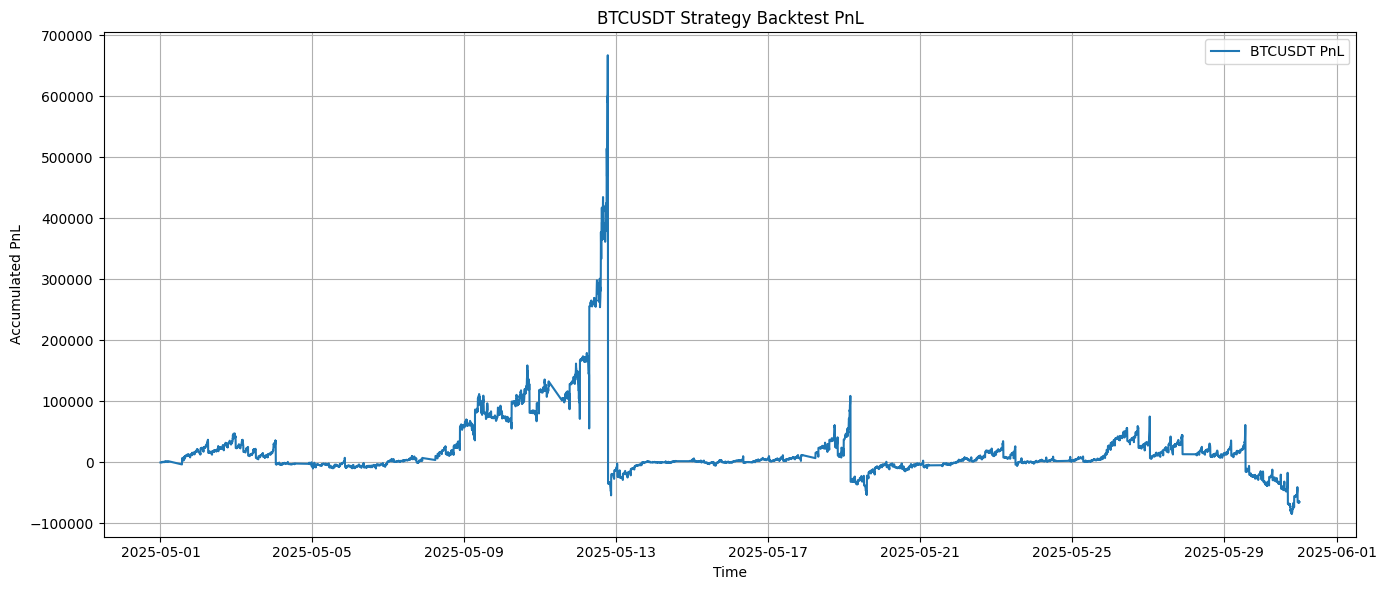

In [328]:
pnl_df = bt.backtest(ticker)

plt.figure(figsize=(14, 6))
plt.plot(pnl_df["timestamp"], pnl_df["PnL_Total"], label=f"{ticker} PnL")
plt.xlabel("Time")
plt.ylabel("Accumulated PnL")
plt.title(f"{ticker} Strategy Backtest PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
